# Linear Regression
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*
## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.head()

,dex,will,level,str,con,cha,reflex,wis,perception,ac,hp,fortitude,int,book,focus
0,2,17,10,7,5,1,19,2,20,29,215,22,1,Pathfinder Bestiary,1
1,0,16,10,9,5,1,14,2,16,28,220,21,-4,Pathfinder Bestiary,0
2,3,15,8,7,6,-2,17,3,17,25,175,20,-4,Pathfinder Bestiary,0
3,4,32,17,7,5,6,29,5,30,41,315,30,6,Pathfinder Bestiary,1
4,3,4,1,-5,1,1,10,1,6,16,20,6,-1,Pathfinder Bestiary,1


## Preprocessing and train test split

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
min_max_df = pd.DataFrame()
min_max_df[characteristics] = pd.DataFrame(scaler.fit_transform(df[characteristics]))
min_max_df["book"] = df["book"]
min_max_df["level"] = df["level"]

In [4]:
min_max_df.head()

,cha,con,dex,int,str,wis,ac,hp,perception,fortitude,reflex,will,focus,book,level
0,0.3750,0.416667,0.4375,0.400000,0.705882,0.333333,0.456522,0.386447,0.434783,0.500000,0.463415,0.395349,0.333333,Pathfinder Bestiary,10
1,0.3750,0.416667,0.3125,0.066667,0.823529,0.333333,0.434783,0.395604,0.347826,0.477273,0.341463,0.372093,0.000000,Pathfinder Bestiary,10
2,0.1875,0.500000,0.5000,0.066667,0.705882,0.416667,0.369565,0.313187,0.369565,0.454545,0.414634,0.348837,0.000000,Pathfinder Bestiary,8
3,0.6875,0.416667,0.5625,0.733333,0.705882,0.583333,0.717391,0.569597,0.652174,0.681818,0.707317,0.744186,0.333333,Pathfinder Bestiary,17
4,0.3750,0.083333,0.5000,0.266667,0.000000,0.250000,0.173913,0.029304,0.130435,0.136364,0.243902,0.093023,0.333333,Pathfinder Bestiary,1


### Chronological split

In [5]:
from training.splitting_dataset import split_dataframe

os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(min_max_df, test_size=0.31)
os.chdir("../notebooks/models/linear_regression")

In [6]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [7]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype
--------------  -----
841 non-null    int64
dtypes: int64(1)
memory usage: 13.1 KB


### Random split

In [8]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(min_max_df, chronological_split=False, test_size=0.25)

In [9]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Linear Regression
### With chronological split

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


model = LinearRegression()
model.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict = model.predict(X_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2 = r2_score(y_train, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.99


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MSE test: {mse:.2f}")
print(f"MAE test: {mae:.2f}")

RMSE train: 0.51
RMSE test: 0.59
MSE test: 0.35
MAE test: 0.44


In [12]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", 13, mse, rmse, mae]

###### MAE by level

In [13]:
from training.results import plot_mae_by_level

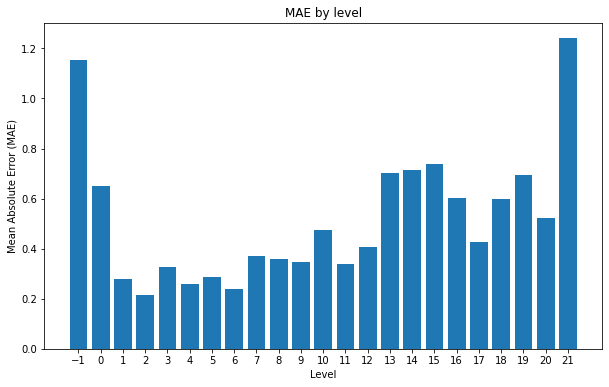

In [14]:
plot_mae_by_level(y_test, y_pred_test)

In [15]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.35
RMSE: 0.59

Round type: round
MSE: 0.35
RMSE: 0.59

Round type: 0.33
MSE: 0.27
RMSE: 0.52

Round type: 0.45
MSE: 0.31
RMSE: 0.56



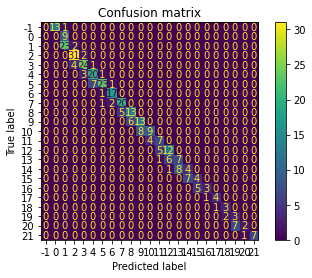

In [16]:
plot_confusion_matrix("round", predict, y_test)

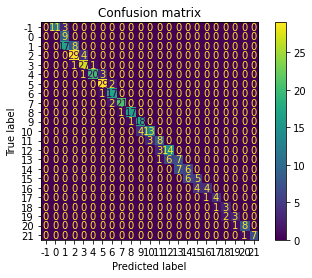

In [17]:
plot_confusion_matrix(0.33, predict, y_test)

### With random split

In [18]:
model = LinearRegression()
model.fit(X_train_random_split, y_train_random_split)

y_pred_train_random_split = model.predict(X_train_random_split)
y_pred_test_random_split = model.predict(X_test_random_split)

r2 = r2_score(y_train_random_split, y_pred_train_random_split)
print(f"R2 score:{r2:.2f}")

R2 score:0.99


In [19]:
rmse_train = mean_squared_error(
    y_train_random_split, y_pred_train_random_split, squared=False
)
rmse = mean_squared_error(y_test_random_split, y_pred_test_random_split, squared=False)
mse = mean_squared_error(y_test_random_split, y_pred_test_random_split)
mae = mean_absolute_error(y_test_random_split, y_pred_test_random_split)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MSE test: {mse:.2f}")
print(f"MAE test: {mae:.2f}")

RMSE train: 0.51
RMSE test: 0.57
MSE test: 0.33
MAE test: 0.38


In [20]:
results.loc[1] = ["random", "normal", 13, mse, rmse, mae]

###### MAE by level

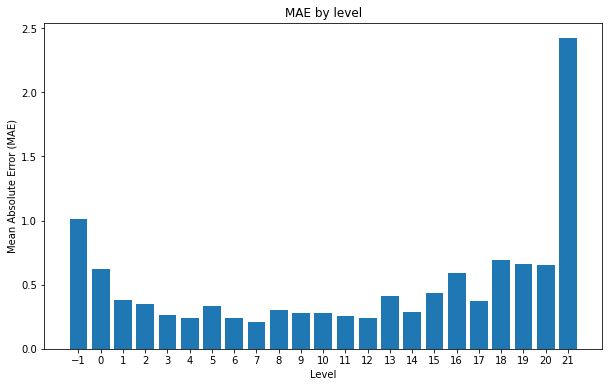

In [21]:
plot_mae_by_level(y_test_random_split, y_pred_test_random_split)

In [22]:
check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, y_pred_test_random_split
)

Normal:
MSE: 0.33
RMSE: 0.57

Round type: round
MSE: 0.22
RMSE: 0.47

Round type: 0.33
MSE: 0.30
RMSE: 0.55

Round type: 0.45
MSE: 0.25
RMSE: 0.50



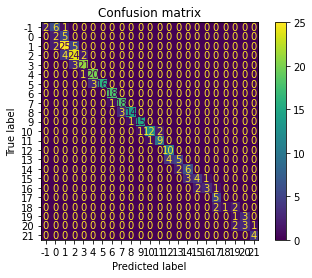

In [23]:
plot_confusion_matrix("round", y_pred_test_random_split, y_test_random_split)

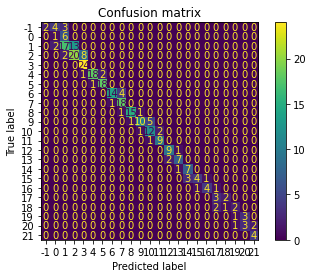

In [24]:
plot_confusion_matrix(0.33, y_pred_test_random_split, y_test_random_split)

## Tuning (ridge, LASSO)

### With chronological split

In [25]:
from sklearn.linear_model import RidgeCV, LassoCV
from training.results import assess_regression_model


reg_ridge_cv = RidgeCV(alphas=np.linspace(0.1, 100, 1000))
reg_lasso_cv = LassoCV(n_alphas=1000, random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train, y_train)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train,
    np.array(y_train).reshape(
        y_train.size,
    ),
)

reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

print(f"Ridge CV alpha: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()

print("Linear Regression")
assess_regression_model(reg_linear, X_train, X_test, y_train, y_test, r2=True)

print("Ridge:")
rmse, mse, mae = assess_regression_model(
    reg_ridge_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[2] = ["chronological", "Ridge", 13, mse, rmse, mae]

print("Lasso:")
rmse, mse, mae = assess_regression_model(
    reg_lasso_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[3] = ["chronological", "Lasso", 13, mse, rmse, mae]

Ridge CV alpha: 0.1000
Lasso CV alpha: 0.0011

Linear Regression
R2: 0.99
RMSE train: 0.51
RMSE test: 0.59
MSE test: 0.35
MAE test: 0.44

Ridge:
R2: 0.99
RMSE train: 0.51
RMSE test: 0.60
MSE test: 0.36
MAE test: 0.44

Lasso:
R2: 0.99
RMSE train: 0.51
RMSE test: 0.60
MSE test: 0.35
MAE test: 0.44



###### MAE by level Ridge

In [26]:
y_pred_test = reg_ridge_cv.predict(X_test)

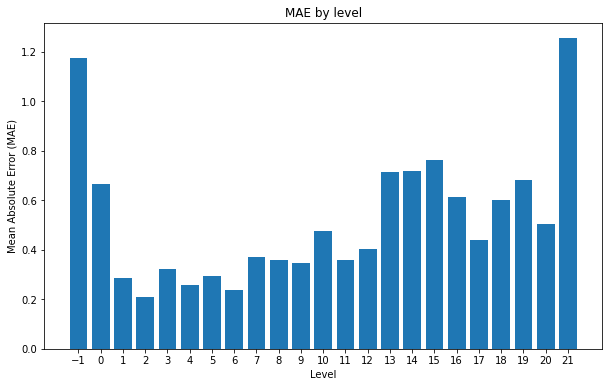

In [27]:
plot_mae_by_level(y_test, y_pred_test)

###### MAE by level LASSO

In [28]:
y_pred_test = reg_lasso_cv.predict(X_test)

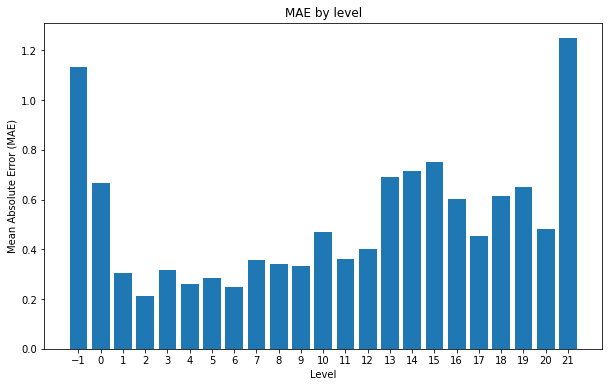

In [29]:
plot_mae_by_level(y_test, y_pred_test)

Index(['cha', 'con', 'dex', 'int', 'str', 'wis', 'ac', 'hp', 'perception',
       'fortitude', 'reflex', 'will', 'focus'],
      dtype='object')
[ 0.15966401 -0.04215937 -0.96236722 -0.32606132 -0.24204247 -1.59888506
  4.46944166  2.92142832  4.58983599  7.41051591  4.69185738  6.34910229
  0.03076898]


<AxesSubplot:title={'center':'Best features'}, ylabel='feature name'>

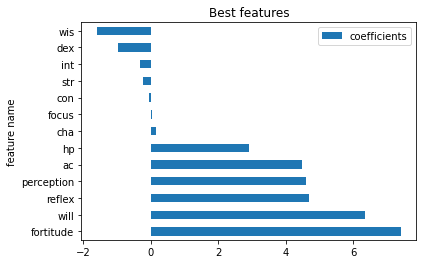

In [30]:
feature_names = X_train.columns
print(feature_names)
print(reg_ridge_cv.coef_)

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": characteristics,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(x="feature name", y="coefficients", title="Best features")

In [31]:
sorted(feature_names[reg_lasso_cv.coef_ == 0])

['con', 'focus']

### With random split

In [32]:
from sklearn.linear_model import RidgeCV, LassoCV

reg_ridge_cv = RidgeCV(alphas=np.linspace(1e-3, 1, 10000))
reg_lasso_cv = LassoCV(alphas=np.linspace(1e-4, 1e-1, 1000), random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train_random_split, y_train_random_split)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train_random_split,
    np.array(y_train_random_split).reshape(
        y_train_random_split.size,
    ),
)

print(f"Ridge CV alphas: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()
print("Ridge:")
rmse, mse, mae = assess_regression_model(
    reg_ridge_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[4] = ["random", "Ridge", 13, mse, rmse, mae]

print("Lasso:")
rmse, mse, mae = assess_regression_model(
    reg_lasso_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[5] = ["random", "Lasso", 13, mse, rmse, mae]

Ridge CV alphas: 0.0655
Lasso CV alpha: 0.0002

Ridge:
R2: 0.99
RMSE train: 0.51
RMSE test: 0.57
MSE test: 0.33
MAE test: 0.38

Lasso:
R2: 0.99
RMSE train: 0.51
RMSE test: 0.57
MSE test: 0.33
MAE test: 0.38



###### MAE by level Ridge

In [33]:
y_pred_test_random_split = reg_ridge_cv.predict(X_test_random_split)

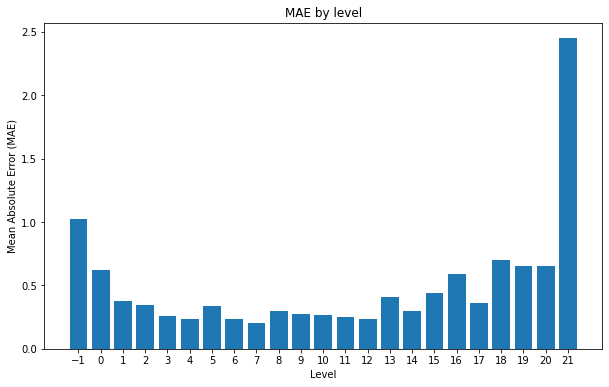

In [34]:
plot_mae_by_level(y_test_random_split, y_pred_test_random_split)

###### MAE by level LASSO

In [35]:
y_pred_test_random_split = reg_lasso_cv.predict(X_test_random_split)

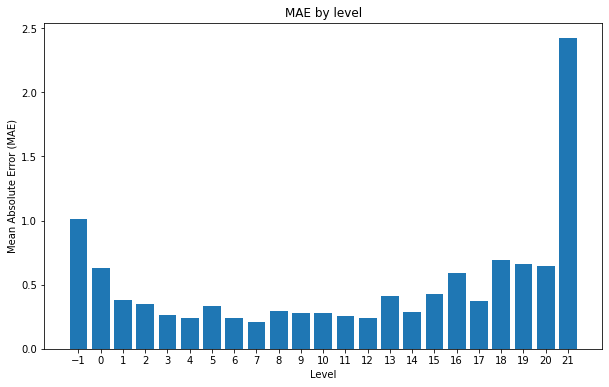

In [36]:
plot_mae_by_level(y_test_random_split, y_pred_test_random_split)

Index(['cha', 'con', 'dex', 'int', 'str', 'wis', 'ac', 'hp', 'perception',
       'fortitude', 'reflex', 'will', 'focus'],
      dtype='object')
[-0.04029849 -0.20180462 -0.8033389  -0.08528507 -0.42889045 -1.68363331
  3.28314464  2.69837156  4.18450569  8.00170401  5.34854699  7.56572541
 -0.35422748]


<AxesSubplot:title={'center':'Best features'}, ylabel='feature name'>

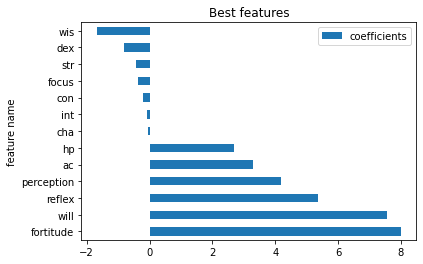

In [37]:
feature_names = X_train.columns
print(feature_names)
print(reg_ridge_cv.coef_)

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": characteristics,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(x="feature name", y="coefficients", title="Best features")

In [38]:
eliminated_features = sorted(feature_names[reg_lasso_cv.coef_ == 0])
print(eliminated_features)

[]


## Summary

In [39]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,13,0.353475,0.594538,0.438196
1,random,normal,13,0.325684,0.570687,0.382039
2,chronological,Ridge,13,0.361328,0.601106,0.441633
3,chronological,Lasso,13,0.354146,0.595102,0.435859
4,random,Ridge,13,0.326834,0.571694,0.380043
5,random,Lasso,13,0.325505,0.570531,0.381640


In [40]:
from training.results import plot_summary

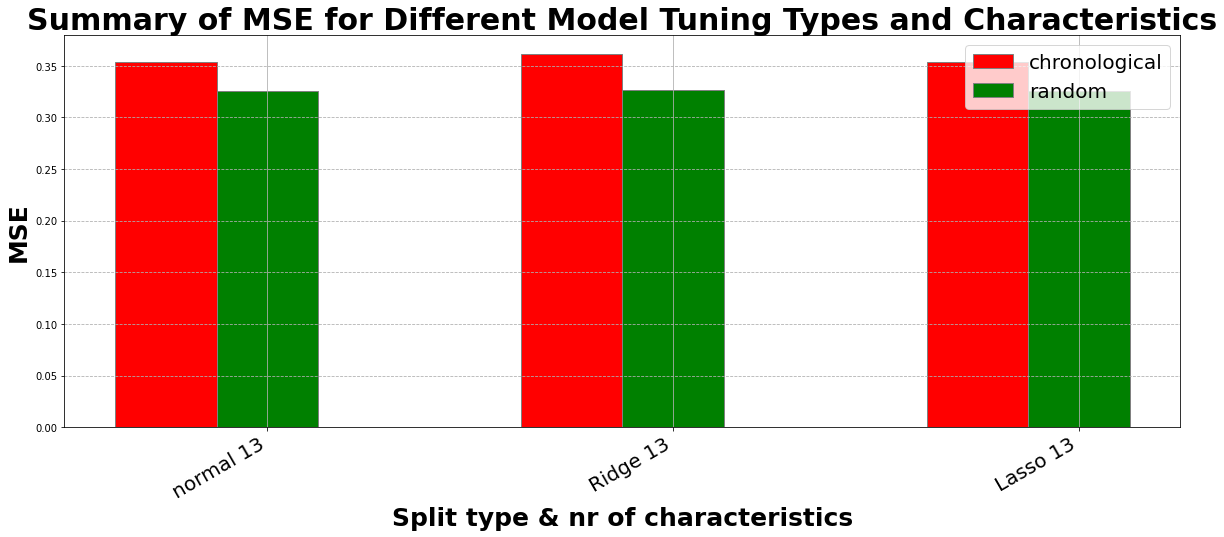

In [41]:
plot_summary(results, "MSE")

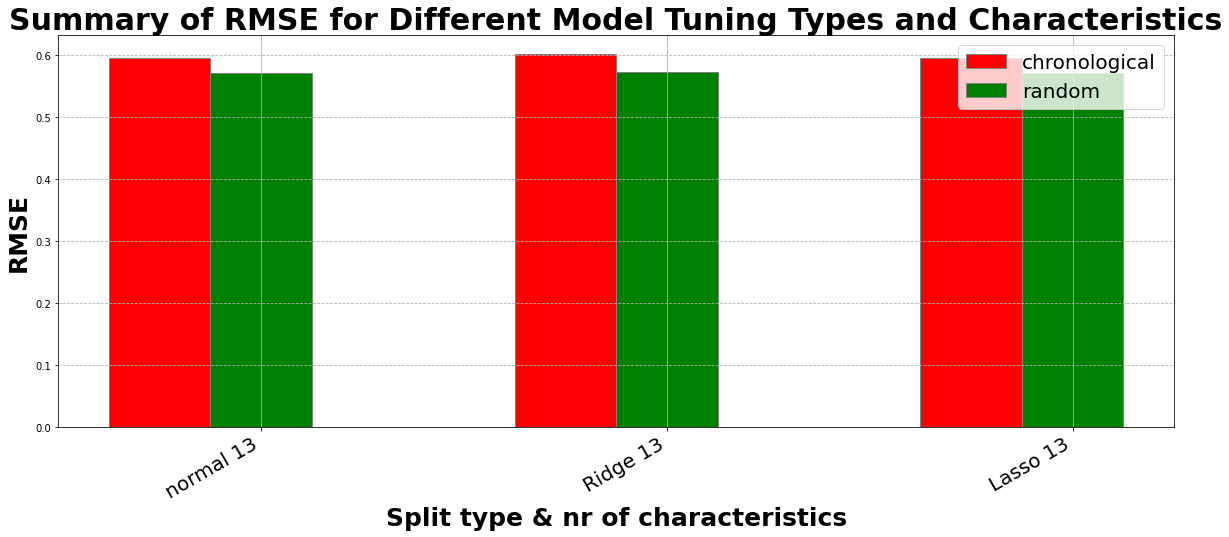

In [42]:
plot_summary(results, "RMSE")

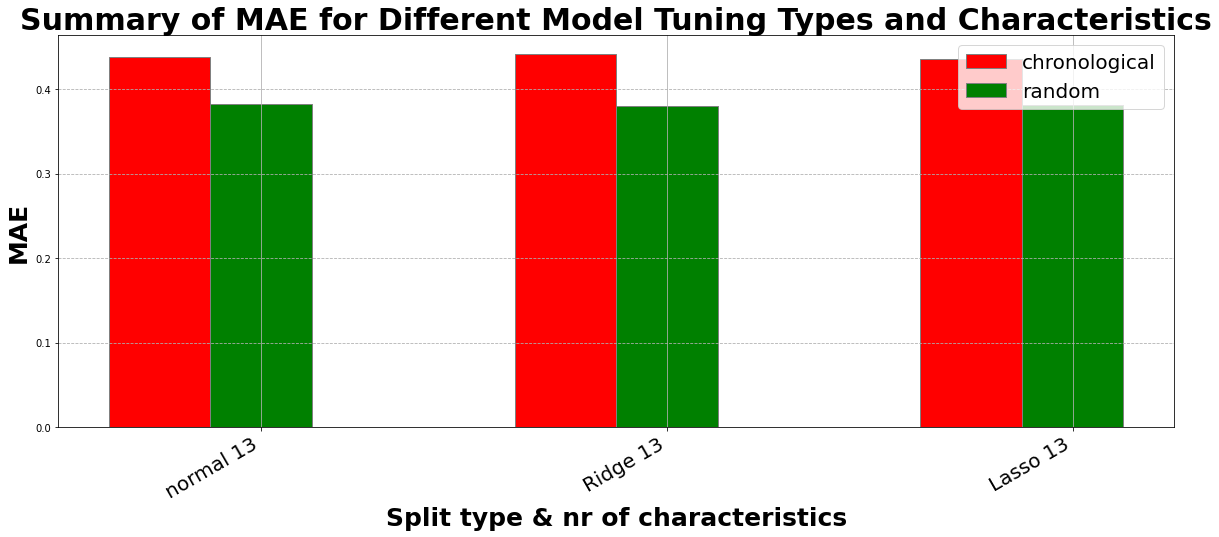

In [43]:
plot_summary(results, "MAE")

In [44]:
results.to_json("./linear_regression_second_results.json")